# SpamAssassin EDA and Preprocessing

## 1 Import libraries

Import the required libraries for data manipulation, email and HTML parsing, text cleaning, and data visualisations.

In [8]:
print("Loading libraries...")

# Core libraries
import os
import pandas as pd
import numpy as np
import re # For regular expressions
import time # To time operations
import gdown
import tarfile
import shutil

# Email parsing
import email
from email import policy
from email.parser import BytesParser
from email.utils import parsedate_to_datetime, getaddresses

# HTML processing
from bs4 import BeautifulSoup

# Text processing
import unicodedata # For NFKC normalisation

# Visualisation (optional for initial EDA here)
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas display options (optional)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

print("Libraries imported.")

Loading libraries...
Libraries imported.


## 2 Load raw SpamAssassin data

Define the base path to extracted SpamAssassin corpus. Then scan the relevant subfolders (`spam`, `spam_2`, `easy_ham`, `easy_ham_2`, `hard_ham`) to collect all email file paths.

In [9]:
spamassassin_archives_on_gdrive = [
    {
        'file_id': '1XDcM_UjL12YRmjvNdJNnSmK7B2T4ATkE',
        'archive_name': 'spam_archive.tar.bz2',
        'expected_folder_after_extraction': 'spam'
    },
    {
        'file_id': '17nSCtXBFlO0qde3V-o3c1aXrmdQKYk2T',
        'archive_name': 'spam_2_archive.tar.bz2',
        'expected_folder_after_extraction': 'spam_2'
    },
    {
        'file_id': '1J7m4n8FXdEVBN6Kmn0B8NHFTDBXbQ8H1',
        'archive_name': 'easy_ham_archive.tar.bz2',
        'expected_folder_after_extraction': 'easy_ham'
    },
    {
        'file_id': '1rgGKQKLhYM6tX6HjYxKOUt35foAZygCd',
        'archive_name': 'hard_ham_archive.tar.bz2',
        'expected_folder_after_extraction': 'hard_ham'
    }
]

NOTEBOOK_DIR = os.getcwd()

# Temporary name change to avoid conflict
RAW_DATA_PARENT_DIR = os.path.join(NOTEBOOK_DIR, 'data_sa', 'raw_sa')

# Final base path
SPAMASSASSIN_BASE_PATH = os.path.join(RAW_DATA_PARENT_DIR, 'spam_assassin_extracted')

# Create the directories if they don't exist
if not os.path.exists(SPAMASSASSIN_BASE_PATH):
    os.makedirs(SPAMASSASSIN_BASE_PATH)
    print(f"Created base directory for extracted files: {SPAMASSASSIN_BASE_PATH}")

# Download and extract each archive
for archive_info in spamassassin_archives_on_gdrive:
    gdrive_url = f'https://drive.google.com/uc?id={archive_info["file_id"]}'

    # Download to current dir first
    local_archive_path = os.path.join(NOTEBOOK_DIR, archive_info['archive_name'])

    # Check if the final extracted folder already exists to avoid re-downloading/extracting
    final_extracted_folder_path = os.path.join(SPAMASSASSIN_BASE_PATH, archive_info['expected_folder_after_extraction'])

    if os.path.exists(final_extracted_folder_path) and os.listdir(final_extracted_folder_path):
        print(f"Folder '{archive_info['expected_folder_after_extraction']}' already exists and is not empty in {SPAMASSASSIN_BASE_PATH}. Skipping download and extraction for {archive_info['archive_name']}.")
        continue

    if not os.path.exists(local_archive_path):
        print(f"Downloading {archive_info['archive_name']} from Google Drive...")
        try:
            gdown.download(gdrive_url, local_archive_path, quiet=False)
            print(f"{archive_info['archive_name']} downloaded.")
        except Exception as e:
            print(f"ERROR downloading {archive_info['archive_name']}: {e}. Please check File ID and share settings on Google Drive.")

            # Skip to next archive if download fails
            continue
    else:
        print(f"{archive_info['archive_name']} already exists locally. Skipping download.")

    # Extract the archive
    if os.path.exists(local_archive_path):
        print(f"Extracting {local_archive_path} to {SPAMASSASSIN_BASE_PATH}...")

        try:
            # tarfile opens .tar.bz2 directly
            with tarfile.open(local_archive_path, "r:bz2") as tar:
                tar.extractall(path=SPAMASSASSIN_BASE_PATH)

            print(f"Successfully extracted {archive_info['archive_name']}.")

        except Exception as e:
            print(f"ERROR extracting {local_archive_path}: {e}")
            print(f"Please ensure it's a valid .tar.bz2 file and that the 'expected_folder_after_extraction' name matches what's inside the archive.")

    else:
        print(f"Archive {local_archive_path} not found for extraction.")

# --- Now, scan the SPAMASSASSIN_BASE_PATH for email files ---
# Define the subfolders we are interested in and their corresponding labels
folders_to_process = {
    # Folder name (must match 'expected_folder_after_extraction' and actual folder name after extraction)
    'spam': {'label': 1, 'category': 'spam_training'},
    'spam_2': {'label': 1, 'category': 'spam_training'},
    'easy_ham': {'label': 0, 'category': 'easy_ham_testing'},
    'hard_ham': {'label': 0, 'category': 'hard_ham_testing'}
}

# List to store dicts of {'filepath': str, 'label': int, 'category': str}
all_email_files_sa = []

if not os.path.exists(SPAMASSASSIN_BASE_PATH) or not os.path.isdir(SPAMASSASSIN_BASE_PATH):
    print(f"ERROR: Final SPAMASSASSIN_BASE_PATH '{SPAMASSASSIN_BASE_PATH}' for processing does not exist or is not a directory.")

else:
    print(f"\nScanning for emails in SpamAssassin base path: {SPAMASSASSIN_BASE_PATH}")

    for folder_name_key, info in folders_to_process.items():
        current_folder_path = os.path.join(SPAMASSASSIN_BASE_PATH, folder_name_key)

        if os.path.isdir(current_folder_path):
            print(f"Scanning folder: {current_folder_path} for label {info['label']} ({info['category']})")
            for item_in_folder in os.listdir(current_folder_path):
                full_path = os.path.join(current_folder_path, item_in_folder)

                # Ensure it's a file
                if os.path.isfile(full_path):

                    # Skip common hidden files or non-email files if any
                    if item_in_folder.startswith('.') or item_in_folder == 'cmds':
                        continue

                    all_email_files_sa.append({'filepath': full_path, 'label': info['label'], 'category': info['category']})
        else:
            print(f"Warning: Subfolder '{folder_name_key}' not found in {SPAMASSASSIN_BASE_PATH}. It might not have been downloaded/extracted, or 'expected_folder_after_extraction' needs checking.")

    print(f"\nFound {len(all_email_files_sa)} total email files to process from SpamAssassin.")

    if all_email_files_sa:
        print("First few entries (filepath, label, category):")
        for entry in all_email_files_sa[:5]:
            print(entry)

Folder 'spam' already exists and is not empty in /content/data_sa/raw_sa/spam_assassin_extracted. Skipping download and extraction for spam_archive.tar.bz2.
Folder 'spam_2' already exists and is not empty in /content/data_sa/raw_sa/spam_assassin_extracted. Skipping download and extraction for spam_2_archive.tar.bz2.
Folder 'easy_ham' already exists and is not empty in /content/data_sa/raw_sa/spam_assassin_extracted. Skipping download and extraction for easy_ham_archive.tar.bz2.
Folder 'hard_ham' already exists and is not empty in /content/data_sa/raw_sa/spam_assassin_extracted. Skipping download and extraction for hard_ham_archive.tar.bz2.

Scanning for emails in SpamAssassin base path: /content/data_sa/raw_sa/spam_assassin_extracted
Scanning folder: /content/data_sa/raw_sa/spam_assassin_extracted/spam for label 1 (spam_training)
Scanning folder: /content/data_sa/raw_sa/spam_assassin_extracted/spam_2 for label 1 (spam_training)
Scanning folder: /content/data_sa/raw_sa/spam_assassin_ext

## 3 Define preprocessing functions

Define the relevant functions to extract the require information, such as sender, subject timestamps, and email body. This includes:

- Text content from email objects, including multipart emails.
- Stripping HTML and retaining hyperlink destinations.
- Perform basic text cleaning such as lowercase, extra whitespace, and special characters.
- Apply NFKC normalisation.

In [10]:
def load_email_content_from_file(filepath):
    try:
        with open(filepath, 'rb') as f: msg = BytesParser(policy=policy.default).parse(f)
        return msg
    except Exception: return None

In [11]:
def get_email_body_and_urls(message_obj):
    """
    Extracts text body and URLs from an email.Message object.
    Tries plain text first, then HTML. Extracts hrefs from  tags in HTML.
    """

    body_text = ""
    html_body_text = ""
    urls_in_html = []

    if message_obj is None: return "", []

    if message_obj.is_multipart():

        for part in message_obj.walk():
            content_type = part.get_content_type(); content_disposition = str(part.get_content_disposition())

            if "attachment" not in content_disposition:

                if content_type == "text/plain" and not body_text:

                    try:
                      payload = part.get_payload(decode=True); charset = part.get_content_charset() or 'utf-8'; body_text = payload.decode(charset, errors='replace')

                    except Exception: pass

                elif content_type == "text/html" and not html_body_text:

                    try:
                        payload = part.get_payload(decode=True); charset = part.get_content_charset() or 'utf-8'; html_content = payload.decode(charset, errors='replace'); html_body_text = html_content
                        soup_part = BeautifulSoup(html_content, 'html.parser')
                        for link_tag in soup_part.find_all('a', href=True): urls_in_html.append(link_tag['href'])

                    except Exception: pass

    # Not multipart
    else:
        content_type = message_obj.get_content_type()

        try:
            payload = message_obj.get_payload(decode=True)
            charset = message_obj.get_content_charset() or 'utf-8'

            if content_type == "text/plain":
              body_text = payload.decode(charset, errors='replace')

            elif content_type == "text/html":
                html_body_text = payload.decode(charset, errors='replace')
                soup_part = BeautifulSoup(html_body_text, 'html.parser')

                for link_tag in soup_part.find_all('a', href=True):
                  urls_in_html.append(link_tag['href'])

        except Exception: pass

    # Logic to decide final body: prefer plain. If not, clean HTML.
    final_body = ""
    if body_text.strip():
      final_body = body_text

    elif html_body_text.strip():
        soup = BeautifulSoup(html_body_text, 'html.parser')

        # Extract text, trying to preserve some structure with spaces
        # Remove script and style elements
        for script_or_style in soup(["script", "style"]):
          script_or_style.decompose()

        final_body = soup.get_text(separator=' ', strip=True)

    # Unique URLs
    return final_body, list(set(urls_in_html))

In [12]:
def clean_text_content(text):
    if not isinstance(text, str):
      return ""

    # NFKC normalisation
    text = unicodedata.normalize('NFKC', text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Replace multiple whitespaces with single
    text = re.sub(r'\s+', ' ', text)

    # Keep basic punctuation and alphanumeric
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'\"$%()]", '', text)

    # Strip text
    text = text.strip()

    return text

In [13]:
def extract_email_headers(message_obj):
    headers = {}

    if message_obj is None:
      return {'subject': '',
              'from_address': '',
              'to_address': '',
              'date_time': pd.NaT,
              'message_id': ''
      }

    try:
        # Ensure it's a string
        headers['subject'] = str(message_obj.get('Subject', ''))

        from_addrs = getaddresses(message_obj.get_all('From', []))
        headers['from_address'] = ', '.join([addr for name, addr in from_addrs if addr])

        to_addrs = getaddresses(message_obj.get_all('To', []))
        headers['to_address'] = ', '.join([addr for name, addr in to_addrs if addr])

        date_str = message_obj.get('Date', '')
        headers['date_time'] = pd.to_datetime(parsedate_to_datetime(date_str), errors='coerce') if date_str else pd.NaT

        headers['message_id'] = str(message_obj.get('Message-ID', ''))

    except Exception:
      headers.setdefault('subject', '')
      headers.setdefault('from_address', '')
      headers.setdefault('to_address', '')
      headers.setdefault('date_time', pd.NaT)
      headers.setdefault('message_id', '')

    return headers

In [14]:
def parse_single_sa_email(file_info_dict):
    """
    Parses an email from its raw string content.
    """

    filepath = file_info_dict['filepath']
    label = file_info_dict['label']
    category = file_info_dict['category']

    message_obj = load_email_content_from_file(filepath)

    if message_obj is None:
        return None

    headers = extract_email_headers(message_obj)
    body_content, urls = get_email_body_and_urls(message_obj)

    return {
        'original_file': filepath,
        'message_id': headers['message_id'],
        'date_time': headers['date_time'],
        'from_address': headers['from_address'],
        'to_address': headers['to_address'],
        'subject_original': headers['subject'],
        'subject_cleaned': clean_text_content(headers['subject']),
        'body_cleaned': clean_text_content(body_content),
        'urls_in_email': urls,
        'body_length': len(body_content),
        'num_urls': len(urls),
        'label': label,
        'sa_category': category
    }

## 4 Apply preprocessing

Process all the collected SpamAssassin email files from the `all_email_files_sa` list (which was populated in Section 2 based on successfully downloaded and extracted archives).

In [15]:
df_processed_sa = pd.DataFrame()

# Check if list exists and is not empty
if 'all_email_files_sa' in globals() and all_email_files_sa:
    print(f"Attempting to process {len(all_email_files_sa)} SpamAssassin emails...")

    processed_sa_list = []
    start_time = time.time()

    for i, file_info in enumerate(all_email_files_sa):
        parsed_data = parse_single_sa_email(file_info)

        if parsed_data:
            processed_sa_list.append(parsed_data)

        # Print progress roughly every 5%
        if (i + 1) % (max(1, len(all_email_files_sa) // 20)) == 0:
             print(f"Processed {i+1}/{len(all_email_files_sa)} SpamAssassin files...")

    df_processed_sa = pd.DataFrame(processed_sa_list)
    end_time = time.time()

    if not df_processed_sa.empty:
        print(f"\nSuccessfully processed {len(df_processed_sa)} SpamAssassin emails in {end_time - start_time:.2f} seconds.")
        print("Processed SpamAssassin head:")
        print(df_processed_sa.head())
        print("\nProcessed SpamAssassin info:")
        df_processed_sa.info()
        print("\nLabel distribution in processed SpamAssassin data:")
        print(df_processed_sa['label'].value_counts(dropna=False))
        print("\nCategory distribution in processed SpamAssassin data:")
        print(df_processed_sa['sa_category'].value_counts(dropna=False))
    else:
        print("No SpamAssassin emails were successfully processed. Check the input file list and parsing functions.")
else:
    print("Variable 'all_email_files_sa' not found or is empty. Ensure Section 2 ran successfully and found email files.")

Attempting to process 4646 SpamAssassin emails...
Processed 232/4646 SpamAssassin files...
Processed 464/4646 SpamAssassin files...
Processed 696/4646 SpamAssassin files...
Processed 928/4646 SpamAssassin files...
Processed 1160/4646 SpamAssassin files...
Processed 1392/4646 SpamAssassin files...
Processed 1624/4646 SpamAssassin files...
Processed 1856/4646 SpamAssassin files...
Processed 2088/4646 SpamAssassin files...
Processed 2320/4646 SpamAssassin files...
Processed 2552/4646 SpamAssassin files...
Processed 2784/4646 SpamAssassin files...
Processed 3016/4646 SpamAssassin files...
Processed 3248/4646 SpamAssassin files...
Processed 3480/4646 SpamAssassin files...
Processed 3712/4646 SpamAssassin files...
Processed 3944/4646 SpamAssassin files...
Processed 4176/4646 SpamAssassin files...
Processed 4408/4646 SpamAssassin files...
Processed 4640/4646 SpamAssassin files...

Successfully processed 4646 SpamAssassin emails in 32.14 seconds.
Processed SpamAssassin head:
                  

## 5 Further EDA on processed data

--- Basic Stats of Processed SpamAssassin Data ---

--- Category: easy_ham_testing ---
Count: 2500
        body_length     num_urls
count   2500.000000  2500.000000
mean    1393.365200     0.024400
std     3267.024124     1.081606
min       47.000000     0.000000
25%      441.000000     0.000000
50%      842.500000     0.000000
75%     1471.250000     0.000000
max    88035.000000    54.000000
Sample subject from this category:
use perl stories for 20020901

--- Category: hard_ham_testing ---
Count: 250
        body_length    num_urls
count     250.00000  250.000000
mean     6574.06000   30.384000
std     13005.45088   29.614466
min        59.00000    0.000000
25%      1996.50000    0.000000
50%      4734.50000   26.000000
75%      8339.00000   54.000000
max    194818.00000  105.000000
Sample subject from this category:
reg headlines wednesday july 17

--- Category: spam_training ---
Count: 1896
         body_length     num_urls
count    1896.000000  1896.000000
mean     2231.427743    

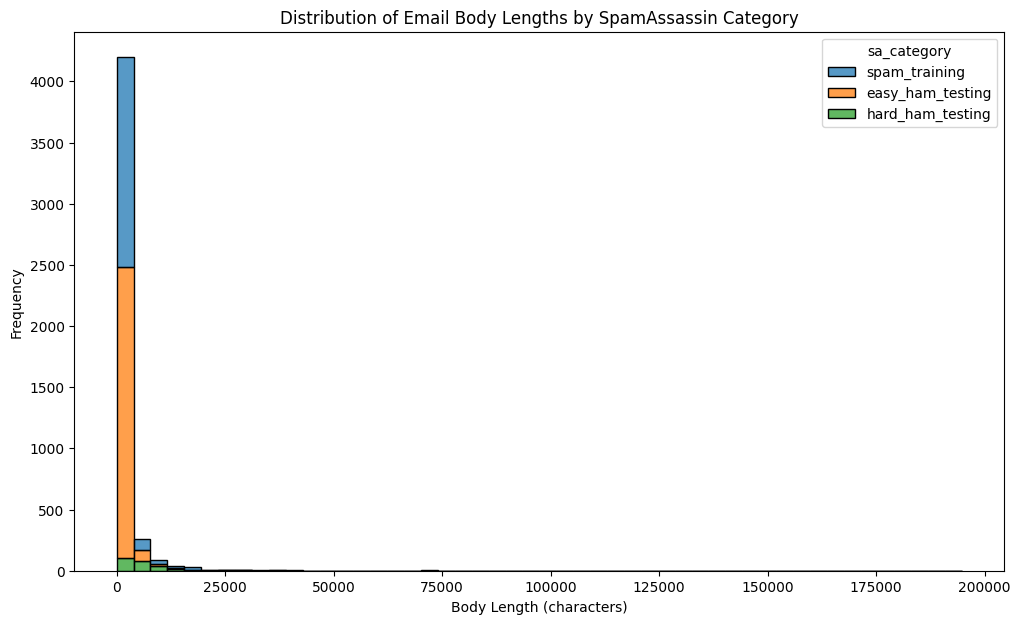

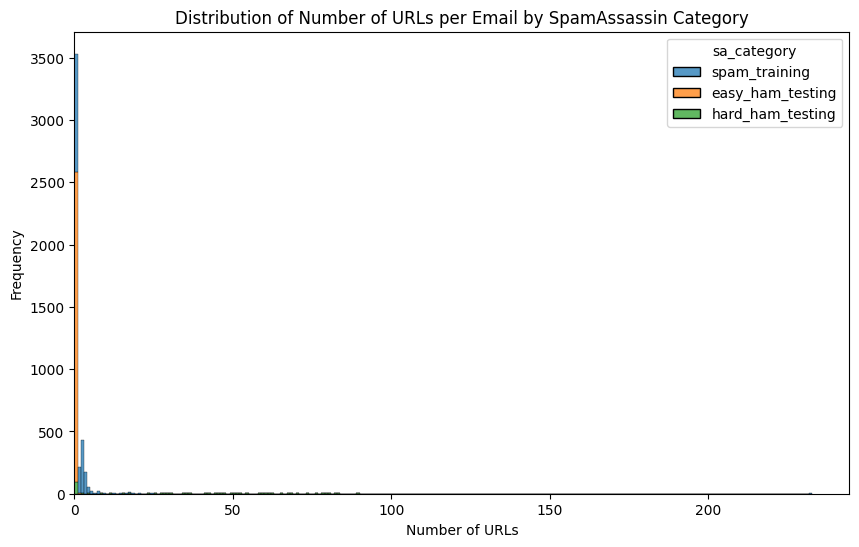

In [16]:
if not df_processed_sa.empty:
    print("--- Basic Stats of Processed SpamAssassin Data ---")

    for category, group_df in df_processed_sa.groupby('sa_category'):
        print(f"\n--- Category: {category} ---")
        print(f"Count: {len(group_df)}")
        print(group_df[['body_length', 'num_urls']].describe())

        if not group_df.empty:
            print("Sample subject from this category:")
            print(group_df['subject_cleaned'].sample(min(1, len(group_df))).iloc[0][:100])

    plt.figure(figsize=(12, 7))
    sns.histplot(data=df_processed_sa, x='body_length', hue='sa_category', bins=50, kde=False, multiple="stack")
    plt.title('Distribution of Email Body Lengths by SpamAssassin Category')
    plt.xlabel('Body Length (characters)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_processed_sa, x='num_urls', hue='sa_category', bins=max(1, df_processed_sa['num_urls'].max() if not df_processed_sa['num_urls'].empty and df_processed_sa['num_urls'].max() > 0 else 1), kde=False, multiple="stack")
    plt.title('Distribution of Number of URLs per Email by SpamAssassin Category')
    plt.xlabel('Number of URLs')
    plt.ylabel('Frequency')
    plt.xlim(left=0)
    plt.show()

else:
    print("Processed SpamAssassin DataFrame is empty. Skipping further EDA.")

## 6 Save processed data into seperate files

Save the processed SpamAssassin data into different files based on their intended use:

- Spam/Phishing emails (from `spam` and `spam_2` categories) for the training set.
- Easy Ham emails (from `easy_ham` category) for a ham test set. (Note: `easy_ham_2` was skipped).
- Hard Ham emails (from `hard_ham` category) for a more challenging ham test set.

In [17]:
if not df_processed_sa.empty:
    # Save Spam/Phishing for Training (category 'spam_training')
    df_sa_spam_for_training = df_processed_sa[df_processed_sa['sa_category'] == 'spam_training'].copy()

    if not df_sa_spam_for_training.empty:
        spam_filename = f'spamassassin_phishing_for_training_{len(df_sa_spam_for_training)}.csv'
        df_sa_spam_for_training.to_csv(spam_filename, index=False)
        print(f"SpamAssassin (phishing/spam for training) data saved to: /content/{spam_filename}")
    else:
        print("No 'spam_training' category emails found in processed SpamAssassin data to save.")

    # Save Easy Ham for Testing (category 'easy_ham_testing')
    df_sa_easy_ham_test = df_processed_sa[df_processed_sa['sa_category'] == 'easy_ham_testing'].copy()
    if not df_sa_easy_ham_test.empty:
        easy_ham_filename = f'spamassassin_easy_ham_test_{len(df_sa_easy_ham_test)}.csv'
        df_sa_easy_ham_test.to_csv(easy_ham_filename, index=False)
        print(f"SpamAssassin (easy ham for testing) data saved to: /content/{easy_ham_filename}")
    else:
        print("No 'easy_ham_testing' category emails found to save.")

    # Save Hard Ham for Testing (category 'hard_ham_testing')
    df_sa_hard_ham_test = df_processed_sa[df_processed_sa['sa_category'] == 'hard_ham_testing'].copy()
    if not df_sa_hard_ham_test.empty:
        hard_ham_filename = f'spamassassin_hard_ham_test_{len(df_sa_hard_ham_test)}.csv'
        df_sa_hard_ham_test.to_csv(hard_ham_filename, index=False)
        print(f"SpamAssassin (hard ham for testing) data saved to: /content/{hard_ham_filename}")
    else:
        print("No 'hard_ham_testing' category emails found to save.")

else:
    print("Processed SpamAssassin DataFrame is empty. Nothing to save.")

SpamAssassin (phishing/spam for training) data saved to: /content/spamassassin_phishing_for_training_1896.csv
SpamAssassin (easy ham for testing) data saved to: /content/spamassassin_easy_ham_test_2500.csv
SpamAssassin (hard ham for testing) data saved to: /content/spamassassin_hard_ham_test_250.csv

IMPORTANT: These files are temporary in Colab runtime. Download them or save to Google Drive for persistence.
